In [77]:
PRFX = 'PrepBbox0908'

In [78]:
INPUT_SHAPE = (1400, 2100)
p_input = '../input'
p_output = f'../output/{PRFX}'
from pathlib import Path
Path(p_output).mkdir(exist_ok=True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
tqdm.pandas()

In [4]:
df = pd.read_csv(f'{p_input}/train.csv')
df.shape

(22184, 2)

# labels

In [21]:
df['Image'] = df.Image_Label.apply(lambda x: x.split('_')[0])
df['Label'] = df.Image_Label.apply(lambda x: x.split('_')[1])
df = df[df.EncodedPixels.notnull()]

In [80]:
lbls = list(set(df.Label))
df_lbls = pd.DataFrame(list(zip(lbls, range(len(lbls)))))
df_lbls

,0,1
0,Gravel,0
1,Fish,1
2,Flower,2
3,Sugar,3


In [81]:
df_lbls.to_csv(f'{p_output}/lbls.csv', index=False, header=None)

In [5]:
def rle2msk(rle, shape=INPUT_SHAPE):
    '''
    rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

# boxes

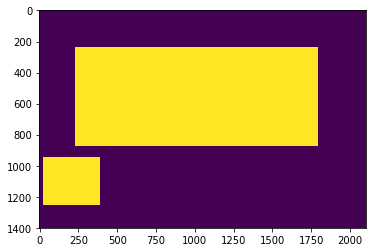

Number of objects is 2


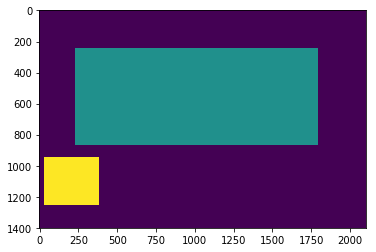

234 241 1788 869
31 947 386 1250


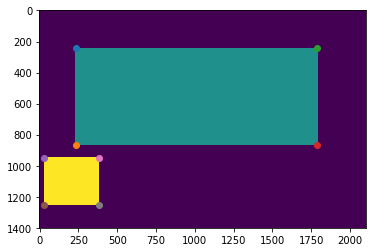

In [17]:
# https://stackoverflow.com/questions/16937158/extracting-connected-objects-from-an-image-in-python
from scipy import ndimage
rle = df.EncodedPixels[df.EncodedPixels.notnull()].sample().values[0]
msk = rle2msk(rle)
plt.imshow(msk)
plt.show()
blur_radius = 1.0
threshold = 0.5

# smooth the image (to remove small objects)
imgf = ndimage.gaussian_filter(msk, blur_radius)

# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is {}".format(nr_objects))

plt.imshow(labeled)
plt.show()

sz_thrsh = 100*100
plt.imshow(labeled)
for lbl in range(1, nr_objects+1):
    if (labeled==lbl).sum()<sz_thrsh: continue
    [(y1, y2), (x1, x2)]= [(o.min(), o.max()) for o in np.where(labeled==lbl)]
    print(x1, y1, x2, y2)
    plt.plot(x1, y1, 'o');
    plt.plot(x1, y2, 'o');
    plt.plot(x2, y1, 'o');
    plt.plot(x2, y2, 'o');
plt.show()


In [22]:
def msk2bboxes(msk):
    res = []
    blur_radius = 1.0
    threshold = 0.5
    sz_thrsh = 100*100
    # smooth the image (to remove small objects)
    imgf = ndimage.gaussian_filter(msk, blur_radius)
    # find connected components
    labeled, nr_objects = ndimage.label(imgf > threshold) 
    for lbl in range(1, nr_objects+1):
        if (labeled==lbl).sum()<sz_thrsh: continue
        [(y1, y2), (x1, x2)]= [(o.min(), o.max()) for o in np.where(labeled==lbl)]
        res.append((x1, y1, x2, y2))
    return res

In [40]:
lst_res = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    Image, Label, rle = row.Image, row.Label, row.EncodedPixels
    msk = rle2msk(rle)
    bboxes = msk2bboxes(msk)
    lst_res += [(Image, *o, Label) for o in bboxes]

100%|██████████| 11836/11836 [16:12<00:00, 12.17it/s]


In [44]:
df_bb = pd.DataFrame(lst_res)

df_bb.columns = ['Image', 'x1', 'y1', 'x2', 'y2', 'Label']
df_bb.sample(5)

,Image,x1,y1,x2,y2,Label
15809,f5efbe6.jpg,17,7,1477,875,Gravel
9393,8f722f2.jpg,1299,834,2094,1394,Gravel
6667,662dd79.jpg,1610,144,2099,731,Fish
15077,eb4d7d7.jpg,808,484,1411,1215,Flower
7815,77490dc.jpg,1350,940,2079,1262,Sugar


In [79]:
df_bb.to_csv(f'{p_output}/boxes.csv', index=False, header=None)

In [73]:
pwd

'/tmp/working/data/git/cld/nbs'

In [72]:
p_output

'../output/Prepbbox0908'

In [76]:
ls /tmp/working/data/git/cld/output/Prepbbox0908/

boxes.csv


In [71]:
ls $p_output

boxes.csv


## verify

In [50]:
df.sample()

,Image_Label,EncodedPixels,Image,Label
8442,601eb93.jpg_Gravel,36423 368 37823 368 39223 368 40623 368 42023 ...,601eb93.jpg,Gravel


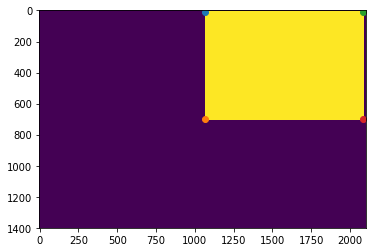

In [70]:
_,rle,image,label = df[df.EncodedPixels.notnull()].sample().values[0]
msk = rle2msk(rle)
plt.imshow(msk)
for v in df_bb[(df_bb.Image==image)&(df_bb.Label==label)].values:
    _,x1, y1, x2, y2,_ = v
    plt.plot(x1, y1, 'o');
    plt.plot(x1, y2, 'o');
    plt.plot(x2, y1, 'o');
    plt.plot(x2, y2, 'o');
plt.show()